<h1 align="center">Fraud Detection with Variational Autoencoder</h1>

- VAE는 vanilla 오토인코더에 비해 훨씬 나은 성능의 이상탐지(anomaly detection) 성능을 제공합니다. 실험을 통해 우리는 기존의 AE는 너무 큰 bottleneck을 가지면 identity function이 되며 이상탐지 성능이 떨어지는 것에 반해, VAE는 bottleneck의 크기가 커질수록 이상탐지 성능이 오르는 효과를 갖는 것을 확인할 수 있었습니다. 따라서 AE 기반의 anomaly detection을 수행할 때, 기존에는 bottleneck의 크기를 hyper-parameter로 튜닝해야 했던 반면에, VAE의 경우에는 튜닝을 할 필요가 거의 없습니다.  


- 신용 카드 데이터를 사용하여 VAE(Variational Autoencoder)를 적용합니다. 기능적으로 Variational Autoencoder는 입력을 재구성하려고 시도하지만 잠재 표현이 입력의 임의의 인코딩이 아닌 입력의 확률 분포의 매개 변수를 학습한다는 추가 제약으로 "Variational"을 개선합니다.  


- 분포를 배우는 것이 좋은 점은,  

    첫째, 데이터 및 노이즈 생성 프로세스를 명시적으로 모델링함으로써 VAE는 더 robust 하게 그 두가지를 분리하는 방법을 배울 수 있습니다.   
    둘째, disentanglement constraint가 적용되면 잠재 공간이 더 해석 가능해집니다.    
    셋째, 잠재 벡터를 샘플링하여 새 샘플을 생성하고 디코더를 통해 파이프할 수 있습니다. 


* disentanglement : latent space가 linear한 구조를 가지게 되어서 하나의 latent vector z 를 움직였을 때 정해진 어떠한 하나의 특성이 변경되게 만들고자 하는 것. 예를 들어, latent vector z 의 specific 한 값을 변경했을 때 생성되는 이미지는 하나의 특성들(머리카락 길이, 성별, 사람의 시선)만 영향을 주게 만들었다고 하면, 이 모델의 latent space는 disentanglement 하다고 말 할 수 있다.

<sup>1</sup> [Building Autoencoders in Keras - Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html)  
<sup>2</sup> [Variational Autoencoders with Tensorflow Probability Layers - Medium](https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7)   
<sup>3</sup> [Google Colab VAE Interactive Example](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb#scrollTo=9clSiUTiT3G1)  
<sup>4</sup> [An, J., & Cho, S. (2015). Variational autoencoder based anomaly detection using reconstruction probability. Special Lecture on IE, 2, 1-18.](https://pdfs.semanticscholar.org/0611/46b1d7938d7a8dae70e3531a00fceb3c78e8.pdf)


### Contents 

1. Variational Autoencoder 훈련
2. 잠재 표현 시각화 (Visualize Latent Representations)
3. VAE vs SVM
4. 테스트 세트에 대한 평가
5. Limitations 

In [1]:
# !pip install tensorflow-probability

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import tensorflow_probability as tfp
tfd = tfp.distributions

np.random.seed(0)
tf.random.set_seed(0)

## Raw Dataset

model train 은 train set 만으로 합니다. test set은 최종 평가 때까지 사용되지 않습니다.

In [3]:
# df = pd.read_csv("data/creditcard.csv")
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- the dataset is highly unbalanced

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
fraud = (df['Class'] == 1).sum()
normal = (df['Class'] == 0).sum()

total = fraud + normal

print(f"Total = {total:,}")
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


- Time 필드를 일중 시간으로 변환합니다.   
- Amount 필드는 로그 스케일로 변환합니다.

In [6]:
df.loc[:, "Time"]   = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) #일중 시간
df.loc[:, 'Amount'] = np.log(df.loc[:, 'Amount'] + 1)

- class 1 이 너무 적으므로 통상적인 7:3 대신 5:5 비율로 train, test set 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1).values , df['Class'].values, 
                                                    test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [8]:
np.bincount(y_train) / len(y_train)

array([0.99825144, 0.00174856])

In [9]:
np.bincount(y_test) / len(y_test)

array([0.99829359, 0.00170641])

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

(1249, 30) (1249,)


findfont: Font family ['NanumBarunGothicBold'] not found. Falling back to DejaVu Sans.


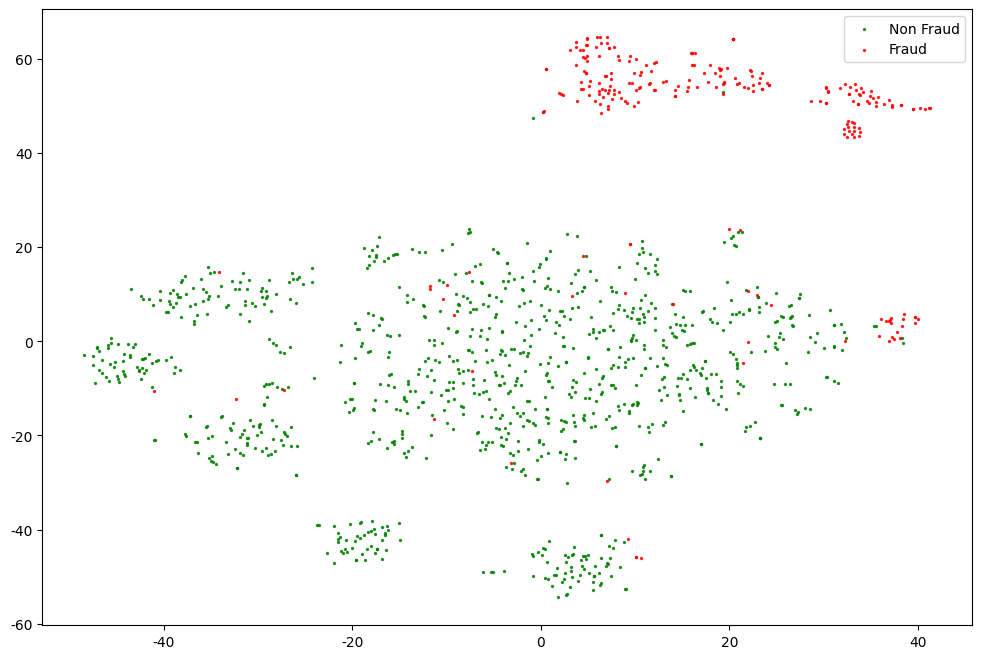

In [11]:
norm, fraud = X_train[y_train == 0], X_train[y_train == 1]

idx = np.random.choice(norm.shape[0], size=1000, replace=False)
tsne_x = np.concatenate([norm[idx], fraud])
tsne_y = np.concatenate([y_train[idx], y_train[y_train == 1]])
print(tsne_x.shape, tsne_y.shape)

tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(tsne_x)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(tsne_y == 0), 0], X_t[np.where(tsne_y == 0), 1], 
            marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud', s=2)

plt.scatter(X_t[np.where(tsne_y == 1), 0], X_t[np.where(tsne_y == 1), 1], 
            marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud', s=2)
plt.legend()
plt.show()

## Train a Variational Autoencoder

latent variable의 prior는 latent dimension의 random unit multivariate normal vector 로 설정 합니다.
latent dimension은 직관적인 illustration 제공을 위해 2로 설정합니다.

인코더의 출력인 잠재 분포 parameter 는 0이 아닌 공분산을 가진 다변수 정규화로 선택 되었습니다. 이는 사기 거래와 정상적인 거래를 분리하는 데 영향을 미치고, 사기 거래의 공분산이 패턴을 가질 수 있기 때문입니다. 결과적으로 학습할 5 개의 distribution parameter가 있습니다 (2 개의 평균값 + 아래쪽 삼각형의 2X2 공분산 행렬에서 가져온 공분산 값 3 개).

디코더의 출력인 데이터 분포 매개 변수는 feature-independent한 정규 분포를 따릅니다. 이 선택은 중요합니다. 온라인에서 찾을 수 있는 대부분의 예제는 출력이 독립적인 베르누이 분포를 따르는 MNIST 데이터 세트와 같은 이진 이미지에 적용되었습니다. 여기서 데이터는 실수 값이며 일반적으로 정규 분포를 따르므로 정규 분포 또는 유사 분포를 사용하여 출력을 모델링하는 것이 합리적입니다. 올바른 분포를 갖는 또 다른 중요한 의미는 훈련 중에 해당 로그 확률 손실을 제공한다는 것입니다. 예를 들어 이진 교차 엔트로피를 사용하여 실수 값 정규 분포를 훈련하는 것은 의미가 없습니다.

In [12]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

X_train_normal.shape, X_train_fraud.shape

((142154, 30), (249, 30))

In [13]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]

X_test_normal.shape, X_test_fraud.shape

((142161, 30), (243, 30))

In [14]:
def encoder_model(input_dim, latent_dim):

    prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)

    encoder_input = Input(shape=(input_dim,))
    x = Dense(20, activation=tf.nn.leaky_relu)(encoder_input)
    x = Dense(15, activation=tf.nn.leaky_relu)(x)
    x = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim), activation=None)(x)
    encoded = tfp.layers.MultivariateNormalTriL(latent_dim, 
                        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior))(x)
    encoder = Model(encoder_input, encoded)
    return encoder

def decoder_model(latent_dim, input_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(15, activation=tf.nn.leaky_relu)(decoder_input)
    x = Dense(20, activation=tf.nn.leaky_relu)(x)
    x = Dense(tfp.layers.IndependentNormal.params_size(input_dim), activation=None)(x)
    decoded = tfp.layers.IndependentNormal(input_dim)(x)

    decoder = Model(decoder_input, decoded)
    return decoder

def vae_model(encoder, decoder):
    vae = Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

    negloglik = lambda x, rv_x: -rv_x.log_prob(x)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=negloglik)
    return vae

In [15]:
input_dim = X_train_normal.shape[1]

latent_dim = 5

encoder = encoder_model(input_dim, latent_dim)

encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                320       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  0         
Total params: 1,255
Trainable params: 1,255
Non-trainable params: 0
_________________________________________________________________


In [16]:
decoder = decoder_model(latent_dim, input_dim)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 60)                1260      
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 1,670
Trainable params: 1,670
Non-trainable params: 0
_________________________________________________________________


In [17]:
vae = vae_model(encoder, decoder)

vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                320       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  0         
_________________________________________________________________
model_1 (Functional)         multiple                  1670      
Total params: 2,925
Trainable params: 2,925
Non-trainable params: 0
_________________________________________________________

In [18]:
#vae.load_weights('bestmodel.h5', by_name=True)

In [19]:
batch_size = 128
max_epochs = 1000

s = time.time()

checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)

earlystopper = EarlyStopping(monitor='val_loss', mode='min', 
                             patience=10, verbose=0, restore_best_weights=True)

history = vae.fit(X_train_normal, X_train_normal, 
                  epochs=max_epochs, batch_size=128, shuffle=True,
                  verbose=1, validation_data=(X_test_normal, X_test_normal),
                  callbacks=[earlystopper, checkpointer])

print(time.time() - s)

Epoch 1/1000
1111/1111 [==============================] - 14s 11ms/step - loss: 35001988.0000 - val_loss: 21427.1855
Epoch 2/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 107.6055 - val_loss: 434294.6875
Epoch 3/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 150.6408 - val_loss: 21158.3828
Epoch 4/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 93.2620 - val_loss: 333.1007
Epoch 5/1000
1111/1111 [==============================] - 11s 9ms/step - loss: 9287.9805 - val_loss: 89.2699
Epoch 6/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 58.6056 - val_loss: 6658.5869
Epoch 7/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 1147.6833 - val_loss: 414.9876
Epoch 8/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 198554.8594 - val_loss: 286818.5938
Epoch 9/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 57.2003 - val_loss: 268

Epoch 76/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 32.1698 - val_loss: 32.1072
Epoch 77/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 32.1602 - val_loss: 32.0852
Epoch 78/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 32.1446 - val_loss: 32.0590
Epoch 79/1000
1111/1111 [==============================] - 12s 11ms/step - loss: 32.1225 - val_loss: 32.0877
Epoch 80/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 32.1314 - val_loss: 32.1095
Epoch 81/1000
1111/1111 [==============================] - 12s 10ms/step - loss: 32.1767 - val_loss: 32.1905
Epoch 82/1000
1111/1111 [==============================] - 12s 10ms/step - loss: 32.0941 - val_loss: 32.0221
Epoch 83/1000
1111/1111 [==============================] - 12s 11ms/step - loss: 32.0526 - val_loss: 32.0218
Epoch 84/1000
1111/1111 [==============================] - 12s 11ms/step - loss: 32.0463 - val_loss: 32.0316
Epoch 85/1000
1111/

1111/1111 [==============================] - 11s 10ms/step - loss: 31.5198 - val_loss: 31.4718
Epoch 151/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.4958 - val_loss: 31.4841
Epoch 152/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.5082 - val_loss: 31.5148
Epoch 153/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.7069 - val_loss: 31.5645
Epoch 154/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.5040 - val_loss: 31.3842
Epoch 155/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.4819 - val_loss: 31.4343
Epoch 156/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.4758 - val_loss: 31.4978
Epoch 157/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.4721 - val_loss: 31.4399
Epoch 158/1000
1111/1111 [==============================] - 11s 10ms/step - loss: 31.5069 - val_loss: 31.3815
Epoch 159/1000
1111/1111 

In [33]:
plt.plot(history.history['loss'])ㅉ

In [20]:
# plt.plot(history.history['loss'])
plt.plot([v for v in history.history['val_loss'] if v < 50])

동일한 숫자의 입력을 정상거래와 사기거래에서 sampling 하여 재구성 분포를 시각화 합니다.

In [21]:
idx = np.random.choice(len(X_train_normal), 250, replace=False)
Nom_data = X_train_normal[idx]
Nom_data.shape 

(250, 30)

In [22]:
Nom_pred = vae.predict(Nom_data)    # AE 결과값 
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) # input - output 간의 MSE 구하기

print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

Normal Metric
       Normal_mse
count  250.000000
mean     1.296061
std      0.928830
min      0.104271
25%      0.672683
50%      1.079398
75%      1.646835
max      5.584687


In [23]:
# Abnormal data 
ANom_pred = vae.predict(X_train_fraud)   # AE 결과값 
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1) # input - output 간의 MSE 구하기

print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

Anomaly Metric
       Anomaly_mse
count   249.000000
mean     43.414876
std      56.536063
min       0.301770
25%       7.793253
50%      17.956584
75%      53.487410
max     306.129257


### MSE 분포 시각화 비교

findfont: Font family ['NanumBarunGothicBold'] not found. Falling back to DejaVu Sans.


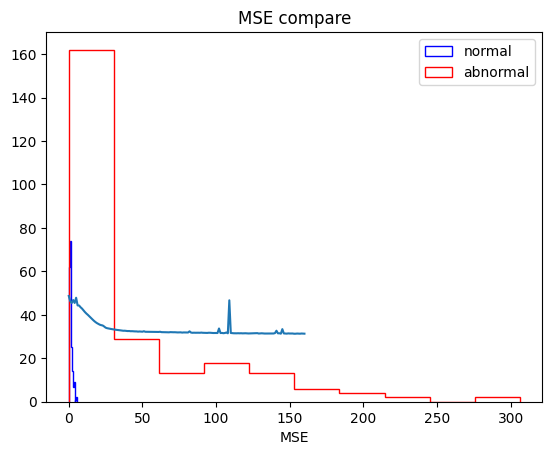

In [24]:
plt.title('MSE compare') 
plt.hist(Nom_pred_mse, bins=10, color='blue', histtype='step', label='normal') 
plt.hist(ANom_pred_mse, bins=10, color='red', histtype='step', label='abnormal') 
plt.xlabel('MSE')
plt.legend()
plt.show()

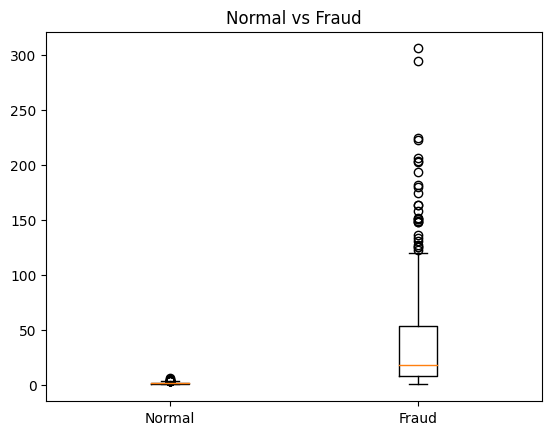

In [25]:
plt.boxplot([Nom_pred_mse, ANom_pred_mse])
plt.title('Normal vs Fraud')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Fraud'])
plt.show()

## Visualize Latent Representations 

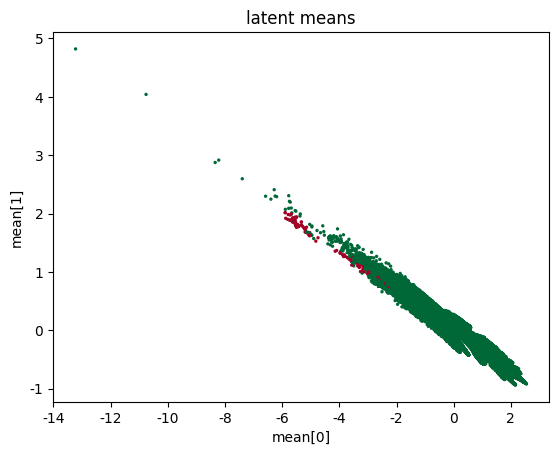

In [26]:
latent_x_mean = encoder(X_test).mean()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

원점 [0,0] 평균 벡터 주변에서 사기와 사기가 아닌 트랜잭션 사이에는 분명한 구분이 있습니다. 이는 VAE가 의미있는 것을 학습하고 있다는 신호입니다.

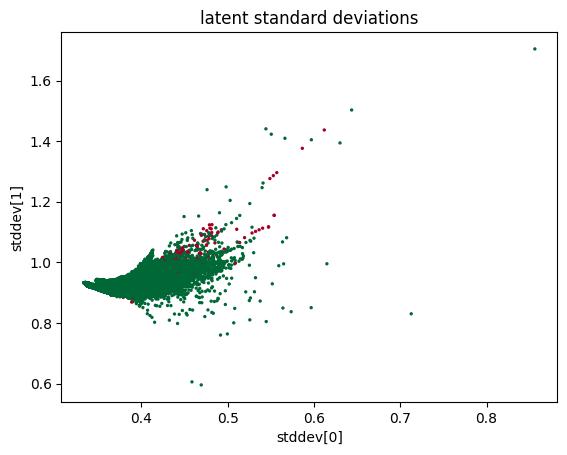

In [27]:
latent_x_std = encoder(X_test).stddev()
plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

빨간색으로 표시된 사기 거래의 표준 편차가 훨씬 더 흩어져 있고 사기 거래가 불규칙한 경향이 있다는 직관과 일치합니다.

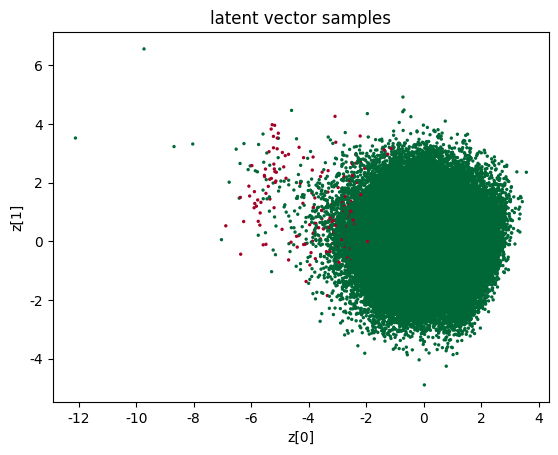

In [28]:
latent_x = encoder(X_test).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

샘플된 잠재 벡터 z입니다. 클러스터링 및 scattering은 이전 관찰과 일치합니다.

##  Reconstruction error threshold
- 정상 data 로만 train 한 vae model 의 재구성 결과의 원본과의 mse 차이를 기준으로 사기 거래 분류

In [29]:
predictions = vae.predict(X_train)

mse = np.mean(np.power(X_train - predictions, 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})

In [30]:
desc = error_df.groupby('true_class').describe()
desc

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      142154.0   1.574176   4.438929  0.010533  0.647512   
1                         249.0  43.177899  55.762062  0.185453  7.741324   

                                              
                  50%        75%         max  
true_class                                    
0            1.098630   1.665120  384.778871  
1           18.087995  58.361494  356.080029

위에서 보듯 사기성이 아닌 거래의  오류는 사기성 거래 보다 낮습니다.

- mean + 3*std를 threshold로 사용하여 test set의 재구성 error(squared error)가 threshold 보다 크면 fraud 거래로 분류합니다.  
- 1 std - 68%, 2 std - 96%, 3 std - 99.8%

In [31]:
mean = desc['reconstruction_error']['mean'][0]
std = desc['reconstruction_error']['std'][0]
thresholds = {'3sigma': mean + 3*std, 
              '2.5sigma': mean + 2.5*std, 
              "2sigma": mean + 2*std}
mean, std, thresholds

(1.5741756346876403,
 4.438929010312455,
 {'3sigma': 14.890962665625004,
  '2.5sigma': 12.671498160468778,
  '2sigma': 10.45203365531255})

Precision 0.11
Recall 0.65


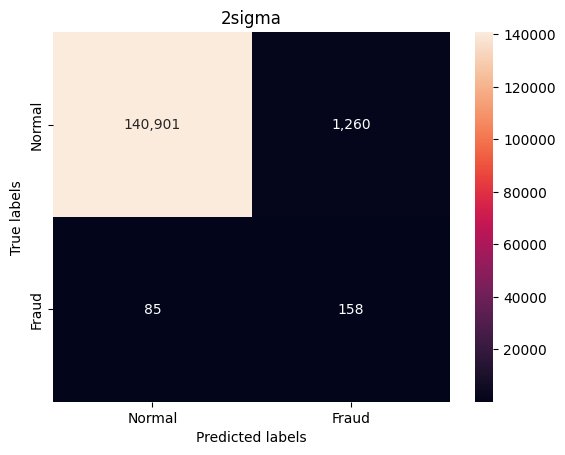

Precision 0.13
Recall 0.58


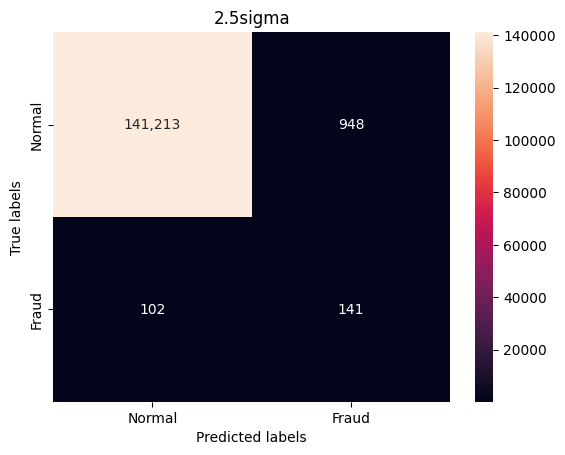

Precision 0.15
Recall 0.55


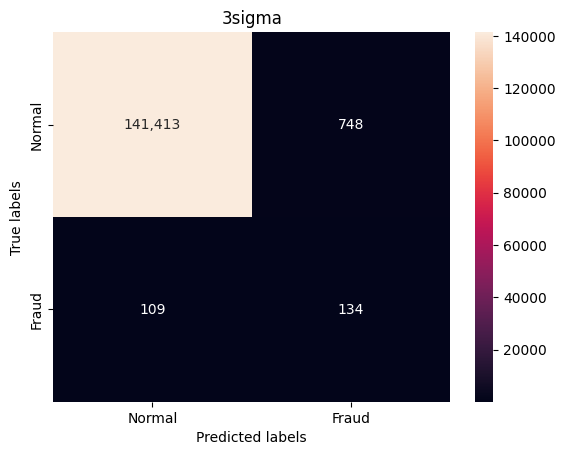

In [32]:
ths = sorted(thresholds.items(), key=lambda kv: kv[1])

for k, threshold in ths:
    
    test_predictions = vae.predict(X_test)
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    y_pred = [(lambda er: 1 if er > threshold else 0)(er) for er in mse]

    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])
    ax.set_title(k)
    plt.show()